# Reading in data

In [305]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import re 
from pandas_profiling import ProfileReport
from sklearn.preprocessing import OneHotEncoder
import sklearn

import matplotlib.pyplot as plt

In [306]:
path = 'alldata/'


In [307]:
def make_dataframes(path):
    file_names = [pos_csv for pos_csv in os.listdir(path) if pos_csv.endswith('.csv')]
    dataframes = {}
    dfs = []
    for i, file in enumerate(file_names):
        df_name = ("df_" + file)[:-4]
        dfs.append(pd.read_csv(path + file))
        dataframes[df_name] = dfs[i]
    return dataframes, file_names

data_dict, files = make_dataframes(path)

In [308]:
# We created a dictionary of dataframes:
data_dict.keys()
# These are the dataframes:

dict_keys(['df_current_log', 'df_weather_log', 'df_weekpop_df', 'df_binned_weather_history', 'df_binned_current_log', 'df_image_label', 'df_ProspectParkSurvey', 'df_curpop_df', 'df_image_label_isa', 'df_Survey_clean'])

# Pre-merge EDA

In [309]:
# We join them on the time_bin column:
data_dict['df_image_label_isa'] = data_dict['df_image_label_isa'].rename(columns={"timetaken": "time_bin"})

In [310]:
def fix_time_format(df):
    """ 
    Turn format to same format for df with 'time_bin' datetime object column.
    """
    print("before:", df['time_bin'].dtype)
    df['time_bin']= pd.to_datetime(df['time_bin']) 
    print("after:", df['time_bin'].dtype)
#    df['time_bin'] = df['time_bin'].dt.strftime('%Y-%m-%d %H:%M')


In [311]:
# Read in pkl tweets into dataframe:
path_to_pkl = "alldata/geotweets_labeled_binned.pkl"

def read_pkl(path_to_pkl):
    tweets = pd.read_pickle(path_to_pkl)
    
    # Create tweets_safe (time bin column, safe score column)
    print(tweets.dtypes)
   # tweets['time_bin'] = tweets['time_bin'].astype(str)
    tweets_safe = tweets[pd.notnull(tweets['safe'])]
#     tweets_safe = tweets.groupby('time_bin').agg(avg_safe=('safe', 'mean'), num_tweets =('time_bin', 'count'))
#     #tweets_safe = tweets.groupby('time_bin').agg({'safe':['mean'], 'safe':['sum']})
#     print(len(tweets_safe))
#     tweets_safe = tweets_safe.drop(columns=['num_tweets'])
#     tweets_safe.columns
    tweets_safe = tweets_safe.reset_index()
    
    # tweets need to be changed to stardard labels: safe = 0, unsafe = 1
    tweets_safe["safe"] = tweets_safe["safe"].replace([0, 1], [1,0])
    
    #fix_time_format(tweets_safe)

    
    # create tweets_count (time bin column, number of tweets)
    tweets_count = tweets.groupby('time_bin').agg(avg_safe=('safe', 'mean'), num_tweets =('time_bin', 'count'))
    tweets_count = tweets_count.drop(columns=['avg_safe'])
    tweets_count = tweets_count.reset_index()
    
    
    return tweets_safe, tweets_count

tweets_safe, tweets_count = read_pkl(path_to_pkl)

date           datetime64[ns, US/Eastern]
text                               object
username                           object
day_of_week                        object
hour                                int64
safe                              float64
time_bin                   datetime64[ns]
dtype: object


In [312]:
considered_dfs = ['df_curpop_df',
                  'df_binned_current_log',
                  'df_image_label_isa',
                  'df_Survey_clean',
                  'df_binned_weather_history']

def convert_and_examine_time(considered_dfs):
    
    for df in considered_dfs:
        print("df name:", df)
        fix_time_format(data_dict[df])
        print('begins:', data_dict[df]['time_bin'].min(), 
              "\nends:", data_dict[df]['time_bin'].max(), 
              "\nnon-na vals:", data_dict[df]['time_bin'].count(), "\n\n" )
    
    print("df name:", "tweets_safe")
    print('begins:', tweets_safe['time_bin'].min(), 
          "\nends:", tweets_safe['time_bin'].max(), 
          "\nnon-na vals:", tweets_safe['time_bin'].count())

# fix_time_format(data_dict['df_curpop_df'])
# fix_time_format(data_dict['df_binned_current_log'])
# fix_time_format(data_dict['df_image_label_isa'])
# fix_time_format(data_dict['df_Survey_clean'])
# fix_time_format(data_dict['df_binned_weather_history'])

convert_and_examine_time(considered_dfs)

df name: df_curpop_df
before: object
after: datetime64[ns]
begins: 2020-04-02 15:05:00 
ends: 2020-04-09 17:05:00 
non-na vals: 663 


df name: df_binned_current_log
before: object
after: datetime64[ns]
begins: 2020-04-04 08:35:00 
ends: 2020-04-10 15:50:00 
non-na vals: 483 


df name: df_image_label_isa
before: object
after: datetime64[ns]
begins: 2020-04-02 16:05:00 
ends: 2020-04-07 18:20:00 
non-na vals: 54 


df name: df_Survey_clean
before: object
after: datetime64[ns]
begins: 2020-03-29 10:50:00 
ends: 2020-04-11 16:20:00 
non-na vals: 22 


df name: df_binned_weather_history
before: object
after: datetime64[ns]
begins: 2019-12-31 23:50:00 
ends: 2020-04-11 22:50:00 
non-na vals: 9789 


df name: tweets_safe
begins: 2020-03-23 14:05:00 
ends: 2020-04-13 07:05:00 
non-na vals: 32


# Make one big dataframe

In [313]:
# Join dataframes on time_bin column:

df_full = pd.merge(data_dict['df_curpop_df'], data_dict['df_binned_weather_history'], on='time_bin', how='outer')

# Standardize models
var_mt = pd.merge(data_dict['df_Survey_clean'][['time_bin','main_track']], df_full, on='time_bin', how='left')
var_mt = var_mt.rename(columns={'main_track':'label'})
var_mt['source'] = "mt"
var_label = pd.merge(data_dict['df_image_label_isa'][['time_bin','label']], df_full, on='time_bin', how='left')
var_mt['source'] = "lab_h"
var_isa = pd.merge(data_dict['df_image_label_isa'][['time_bin','Isa']], df_full, on='time_bin', how='left')
var_isa = var_isa.rename(columns={'Isa':'label'})
var_mt['source'] = "lab_i"
var_safe = pd.merge(tweets_safe[['time_bin','safe']], df_full, on='time_bin', how='left')
var_safe = var_safe.rename(columns={'safe':'label'})
var_mt['source'] = "tw"

# Join frames together
frames = [var_mt, var_label, var_isa, var_safe]
df_full = result = pd.concat(frames)

# Create day/hour variables (since we suspect these may be relevant to how safe/unsafe PP is at in a given time_bin)
df_full['day_name'] = df_full['time_bin'].dt.day_name()
df_full['hour'] = df_full['time_bin'].dt.hour


In [314]:
df_full

,time_bin,label,Unnamed: 0,current_popularity,datetime,time,temperature,dewpoint,humidity,precipitation,windspeed,winddirection,pressure,source,day_name,hour
0,2020-04-08 18:20:00,1.0,579.0,43.0,4/8/2020 18:24,NaN,62.060,9.40,62.0,0.0,20.35,345.0,1001.250,tw,Wednesday,18
1,2020-04-08 18:20:00,1.0,580.0,40.0,4/8/2020 18:34,NaN,62.060,9.40,62.0,0.0,20.35,345.0,1001.250,tw,Wednesday,18
2,2020-04-04 15:50:00,2.0,201.0,63.0,4/4/2020 15:53,2020-04-04 16:00:00,51.980,5.60,69.0,0.0,14.80,40.0,1016.800,tw,Saturday,15
3,2020-04-04 15:50:00,2.0,202.0,69.0,4/4/2020 16:03,2020-04-04 16:00:00,51.980,5.60,69.0,0.0,14.80,40.0,1016.800,tw,Saturday,15
4,2020-04-07 18:20:00,1.0,488.0,42.0,4/7/2020 18:21,NaN,61.520,1.30,36.0,0.0,22.15,195.0,1011.500,tw,Tuesday,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36,2020-04-08 21:20:00,1.0,NaN,NaN,NaN,NaN,63.500,8.85,57.0,0.0,22.30,350.0,1001.550,NaN,Wednesday,21
37,2020-04-09 08:50:00,1.0,613.0,21.0,4/9/2020 8:55,2020-04-09 09:00:00,46.040,7.20,96.0,0.0,5.40,140.0,1001.200,NaN,Thursday,8
38,2020-04-11 18:05:00,1.0,NaN,NaN,NaN,NaN,52.475,-6.30,28.5,0.0,31.15,267.5,1012.525,NaN,Saturday,18
39,2020-04-12 09:50:00,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sunday,9


# Post-merge EDA

In [315]:
# Pandas profiling Report
# profile = ProfileReport(df_full, title='report', html={'style':{'full_width':True}})
# profile.to_file(output_file="report.html")

In [316]:
# We can see we are missing a lot of data for some variables:
df_full.count()

time_bin              240
label                 239
Unnamed: 0            220
current_popularity    220
datetime              220
time                   70
temperature           238
dewpoint              238
humidity              238
precipitation         238
windspeed             238
winddirection         238
pressure              238
source                 31
day_name              240
hour                  240
dtype: int64

In [317]:
df_full.shape

(240, 16)

Project criteria: **We will only include data from March 23rd, 2020 onward**:

In [318]:
df = df_full[df_full['time_bin'] >= '3/23/2020 00:00']
print("before filtering:", df_full.shape, "\nafter filtering:", df.shape)

before filtering: (240, 16) 
after filtering: (240, 16)


# Building a target variable, and some feature engineering

We have a few variables we can use to build a labelled column - we have a lot of missing values, so we can cobble a target variable using different columns:

- main_track: from survey data on how busy the main track of the park is (df_Survey_clean)
- label, Isa: from photos (df_image_label_isa)
- tweets_safe: from twitter scraping data


In [319]:
print(df['time_bin'].nunique())
print(len(df))

98
240


Naively drop any target variables that we don't have zeros or ones for:

In [320]:
print(df['label'].value_counts(dropna=False))
df = df[df['label'].notna()]
print(df['label'].value_counts(dropna=False))
print(df['label'].dtypes)
print(df.columns)
df = df[['time_bin', 'label', 'current_popularity',
       'temperature', 'humidity', 'precipitation',
       'windspeed', 'day_name', 'source', 'hour']]
df = df[df['label']!=2]
print(df['label'].value_counts(dropna=False))
print(df.columns)

0.0    114
1.0     82
2.0     43
NaN      1
Name: label, dtype: int64
0.0    114
1.0     82
2.0     43
Name: label, dtype: int64
float64
Index(['time_bin', 'label', 'Unnamed: 0', 'current_popularity', 'datetime',
       'time', 'temperature', 'dewpoint', 'humidity', 'precipitation',
       'windspeed', 'winddirection', 'pressure', 'source', 'day_name', 'hour'],
      dtype='object')
0.0    114
1.0     82
Name: label, dtype: int64
Index(['time_bin', 'label', 'current_popularity', 'temperature', 'humidity',
       'precipitation', 'windspeed', 'day_name', 'source', 'hour'],
      dtype='object')


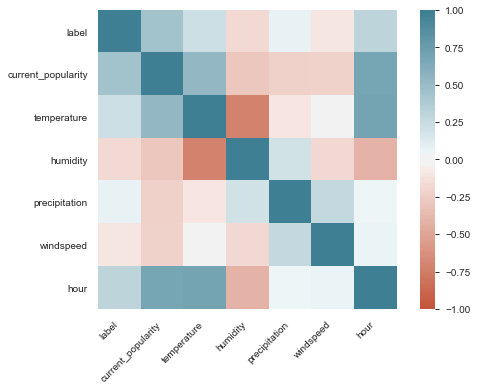

In [321]:
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

We can probably do something a bit more meaningful by exploding day_name:

In [322]:
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')

# passing cat column (label encoded values of bridge_types)
enc_df = pd.DataFrame(enc.fit_transform(df[['day_name']]).toarray())

# merge with main df bridge_df on key values
df_m = df.join(enc_df)
df_m.head(1)


,time_bin,label,current_popularity,temperature,humidity,precipitation,windspeed,day_name,source,hour,0,1,2,3,4,5,6
0,2020-04-08 18:20:00,1.0,43.0,62.06,62.0,0.0,20.35,Wednesday,tw,18,0.0,0.0,0.0,0.0,0.0,0.0,1.0


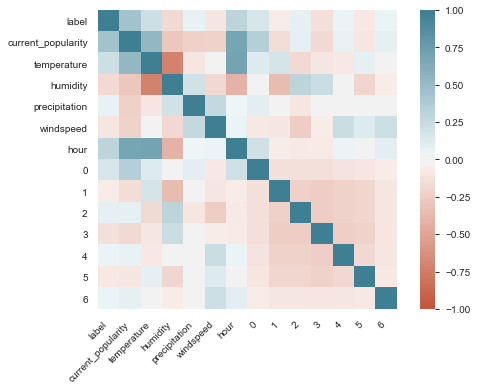

In [323]:
corr = df_m.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Look at some counts w/crosstab:

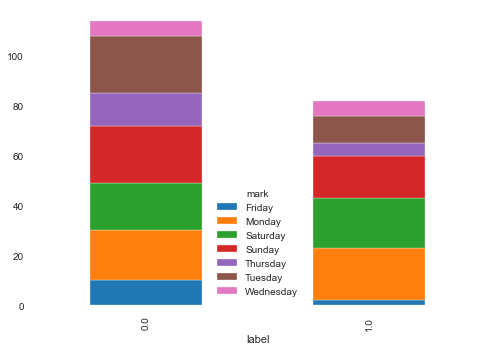

In [324]:
# Table of survival vs passenger class
t1 = pd.crosstab(index=df_m["label"], columns=df_m["day_name"])
t1.plot.bar(stacked=True)
plt.legend(title='mark')

plt.show()

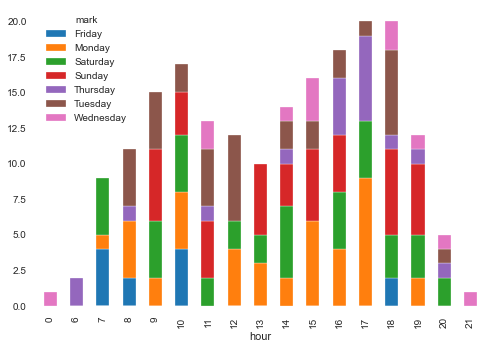

In [325]:
t2 = pd.crosstab(index=df_m["hour"], columns=df_m["day_name"])

t2.plot.bar(stacked=True)
plt.legend(title='mark')

plt.show()

In [326]:
t3 = pd.crosstab(index=df_m["label"], columns=df_m["hour"])
t3

hour,0,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
label,,,,,,,,,,,,,,,,,
0.0,1,2,9,8,12,14,9,9,5,3,7,7,8,6,10,4,0
1.0,0,0,0,3,3,3,4,3,5,11,9,11,12,14,2,1,1


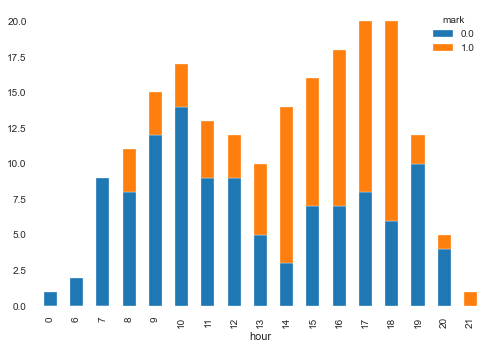

In [327]:
t4 = pd.crosstab(index=df_m["hour"], columns=df_m["label"])

t4.plot.bar(stacked=True)
plt.legend(title='mark')

plt.show()

# Models

In [344]:
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [329]:
df_m = df_m[['label', 'current_popularity', 'temperature', 'precipitation', 'windspeed', 'hour', 0,1,2,3,4,5,6]]
df_m.head(1)

,label,current_popularity,temperature,precipitation,windspeed,hour,0,1,2,3,4,5,6
0,1.0,43.0,62.06,0.0,20.35,18,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [338]:
print(df_m.shape)
df_m = df_m.dropna()
print(df_m.shape)

(176, 13)
(176, 13)


In [357]:
x = df_m.drop('label',axis = 1)
y = df_m['label']

# Split data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=4)

# Create model
clf = LogisticRegression(random_state=0).fit(x_train, y_train)


y_pred = clf.predict(x_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
accuracy_percentage = 100 * accuracy

print("accuracy:", accuracy_percentage)
print("\nClassificationReport")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix")

# cm = confusion_matrix(y.tolist(), y_pred.tolist())

# fig, ax = plt.subplots(figsize=(8, 8))
# ax.imshow(cm)
# ax.grid(False)
# ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
# ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
# ax.set_ylim(1.5, -0.5)
# for i in range(2):
#     for j in range(2):
#         ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
# plt.show()

# print(confusion_matrix)


accuracy: 63.63636363636363

ClassificationReport
              precision    recall  f1-score   support

         0.0       0.63      0.79      0.70        24
         1.0       0.64      0.45      0.53        20

    accuracy                           0.64        44
   macro avg       0.64      0.62      0.62        44
weighted avg       0.64      0.64      0.62        44


Confusion Matrix


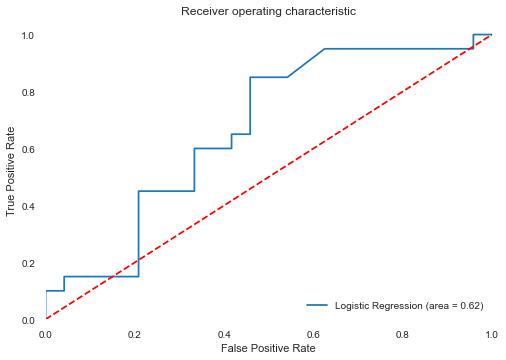

In [349]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, clf.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()